![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)
----
# SAMSum Dataset Exploration
----

This notebook analyzes the SAMSum dataset used throughout the project.

It covers:

- Structural features (turns, speakers)
- Dialogue/summary lengths (chars, words)
- Compression ratios
- N-gram distributions
- Side-by-side comparisons across **train**, **validation**, and **test**

All charts and tables can be enabled/disabled via flags.

The dataset loading is handled in `src/data/load_data.py` so each notebook stays isolated.

In [1]:
# Configuration flags
SHOW_CHARTS = True      # Set False when feeding into LLMs
SHOW_TABLES = True      # Set False for final commit if you want visuals only
NGRAM_SAMPLE_SIZE = 4000
SEED = 42

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import os
import sys
from pathlib import Path

# Allow imports from project root
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Correct refactored location of load_samsum
from src.data.load_data import load_samsum

/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_df, val_df, test_df = load_samsum()

print(len(train_df), len(val_df), len(test_df))

14731 818 819


In [4]:
def parse_dialogue_turns(dialogue: str):
    turns = []
    for line in dialogue.split("\n"):
        line = line.strip()
        if not line:
            continue
        if ":" in line:
            speaker, utt = line.split(":", 1)
            turns.append((speaker.strip(), utt.strip()))
        else:
            turns.append(("UNKNOWN", line))
    return turns


def add_structure_features(df):
    df = df.copy()
    n_turns = []
    n_speakers = []

    for dlg in df["dialogue"]:
        turns = parse_dialogue_turns(dlg)
        speakers = {spk for spk, _ in turns}
        n_turns.append(len(turns))
        n_speakers.append(len(speakers))

    df["n_turns"] = n_turns
    df["n_speakers"] = n_speakers
    return df


def add_length_features(df, show_empty_examples: bool = True):
    """
    Add length-based features to the dataframe.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with 'dialogue' and 'summary' columns
    show_empty_examples : bool
        If True, display examples of any empty dialogues/summaries found
    
    Returns
    -------
    pd.DataFrame
        Copy of input with additional columns:
        - dialogue_char_len, summary_char_len
        - dialogue_word_len, summary_word_len
        - summary_fraction (NaN for problematic rows)
        - has_empty_dialogue, has_empty_summary (boolean flags)
    """
    df = df.copy()
    
    # Basic length features
    df["dialogue_char_len"] = df["dialogue"].str.len()
    df["summary_char_len"] = df["summary"].str.len()
    df["dialogue_word_len"] = df["dialogue"].str.split().str.len()
    df["summary_word_len"] = df["summary"].str.split().str.len()
    
    # Create explicit flags for empty content
    df["has_empty_dialogue"] = df["dialogue_word_len"] == 0
    df["has_empty_summary"] = df["summary_word_len"] == 0
    
    # Calculate summary fraction, handling division by zero
    # - Empty dialogue (0 words) → NaN (can't compute ratio)
    # - Empty summary (0 words) → NaN (not meaningful)
    # - Both empty (0/0) → NaN
    safe_dialogue_len = df["dialogue_word_len"].replace(0, np.nan)
    safe_summary_len = df["summary_word_len"].replace(0, np.nan)
    df["summary_fraction"] = safe_summary_len / safe_dialogue_len
    
    # Detailed reporting
    empty_dialogues = df["has_empty_dialogue"].sum()
    empty_summaries = df["has_empty_summary"].sum()
    both_empty = (df["has_empty_dialogue"] & df["has_empty_summary"]).sum()
    
    print(f"  📊 Data Quality Report:")
    print(f"     Total rows: {len(df)}")
    
    if empty_dialogues > 0:
        print(f"     ⚠️  Empty dialogues (0 words): {empty_dialogues}")
        if show_empty_examples:
            empty_dlg_df = df[df["has_empty_dialogue"]][["dialogue", "summary"]].head(3)
            for idx, row in empty_dlg_df.iterrows():
                dlg_preview = repr(row['dialogue'][:50]) if row['dialogue'] else "''"
                print(f"        ID {idx}: dialogue={dlg_preview}")
    
    if empty_summaries > 0:
        print(f"     ⚠️  Empty summaries (0 words): {empty_summaries}")
        if show_empty_examples:
            empty_sum_df = df[df["has_empty_summary"]][["dialogue", "summary"]].head(3)
            for idx, row in empty_sum_df.iterrows():
                print(f"        ID {idx}: summary={repr(row['summary'])}")
    
    if both_empty > 0:
        print(f"     ⚠️  Both empty (dialogue AND summary): {both_empty}")
    
    total_problematic = (df["has_empty_dialogue"] | df["has_empty_summary"]).sum()
    if total_problematic > 0:
        pct = total_problematic / len(df) * 100
        print(f"     📉 Total problematic rows: {total_problematic} ({pct:.2f}%)")
        print(f"        These rows will have NaN for summary_fraction")
    else:
        print(f"     ✓ No empty dialogues or summaries found")
    
    return df







In [5]:
train = add_length_features(add_structure_features(train_df))
val   = add_length_features(add_structure_features(val_df))
test  = add_length_features(add_structure_features(test_df))

  📊 Data Quality Report:
     Total rows: 14731
     ✓ No empty dialogues or summaries found
  📊 Data Quality Report:
     Total rows: 818
     ✓ No empty dialogues or summaries found
  📊 Data Quality Report:
     Total rows: 819
     ✓ No empty dialogues or summaries found


In [6]:
summary_tables = {
    "train": train.describe(),
    "validation": val.describe(),
    "test": test.describe(),
}

if SHOW_TABLES:
    for name, df in summary_tables.items():
        print(f"\n=== {name.upper()} — DESCRIPTIVE STATS ===")
        display(df)


=== TRAIN — DESCRIPTIVE STATS ===


,n_turns,n_speakers,dialogue_char_len,summary_char_len,dialogue_word_len,summary_word_len,summary_fraction
count,14731.000000,14731.000000,14731.000000,14731.000000,14731.000000,14731.000000,14731.000000
mean,11.167266,2.394610,502.307922,110.139027,93.792750,20.318444,0.295947
std,6.452542,0.828921,397.639839,60.891699,74.031937,11.153570,0.175506
min,3.000000,2.000000,29.000000,3.000000,7.000000,1.000000,0.015385
25%,6.000000,2.000000,212.000000,63.000000,39.000000,12.000000,0.170213
50%,10.000000,2.000000,392.000000,96.000000,73.000000,18.000000,0.256410
75%,15.000000,3.000000,681.000000,144.000000,128.000000,27.000000,0.379310
max,46.000000,14.000000,5474.000000,300.000000,803.000000,64.000000,1.888889



=== VALIDATION — DESCRIPTIVE STATS ===


,n_turns,n_speakers,dialogue_char_len,summary_char_len,dialogue_word_len,summary_word_len,summary_fraction
count,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000
mean,10.831296,2.387531,490.778729,110.174817,91.641809,20.283619,0.301459
std,6.376279,0.836845,398.527392,61.388822,74.479672,11.211454,0.173940
min,3.000000,2.000000,55.000000,17.000000,10.000000,3.000000,0.019553
25%,6.000000,2.000000,202.500000,63.000000,38.000000,12.000000,0.173115
50%,9.000000,2.000000,378.000000,96.000000,70.000000,18.000000,0.266615
75%,14.000000,3.000000,675.750000,144.000000,127.000000,26.000000,0.387663
max,30.000000,12.000000,2923.000000,300.000000,540.000000,59.000000,1.000000



=== TEST — DESCRIPTIVE STATS ===


,n_turns,n_speakers,dialogue_char_len,summary_char_len,dialogue_word_len,summary_word_len,summary_fraction
count,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000
mean,11.247863,2.360195,512.457875,108.780220,95.507937,20.017094,0.290010
std,6.352394,0.827952,404.247406,58.461389,75.225291,10.654829,0.173449
min,3.000000,2.000000,47.000000,17.000000,9.000000,3.000000,0.032895
25%,6.000000,2.000000,222.000000,63.000000,42.000000,12.000000,0.162835
50%,10.000000,2.000000,394.000000,96.000000,74.000000,18.000000,0.250000
75%,15.000000,2.000000,674.000000,142.000000,126.000000,26.000000,0.384615
max,30.000000,11.000000,2769.000000,300.000000,516.000000,58.000000,1.222222


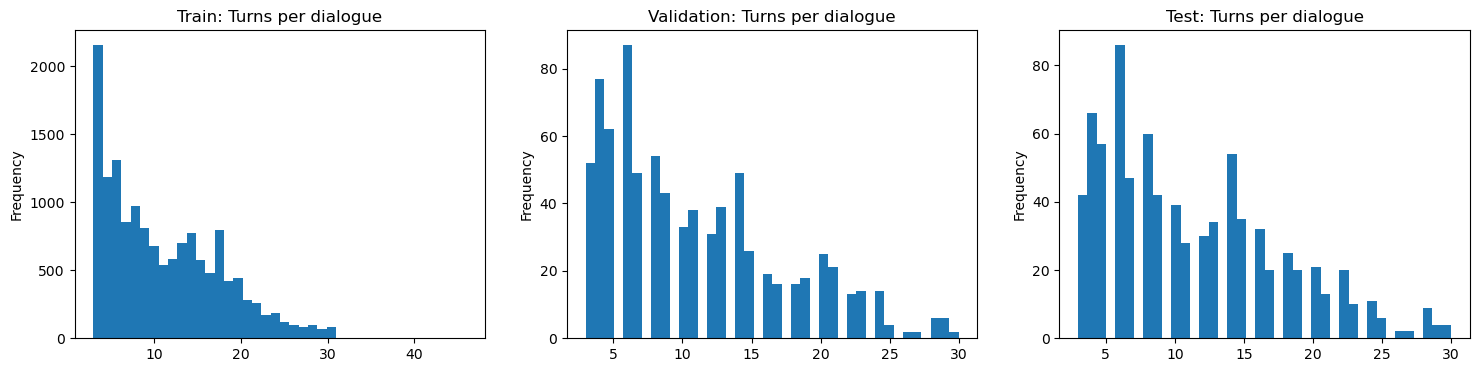

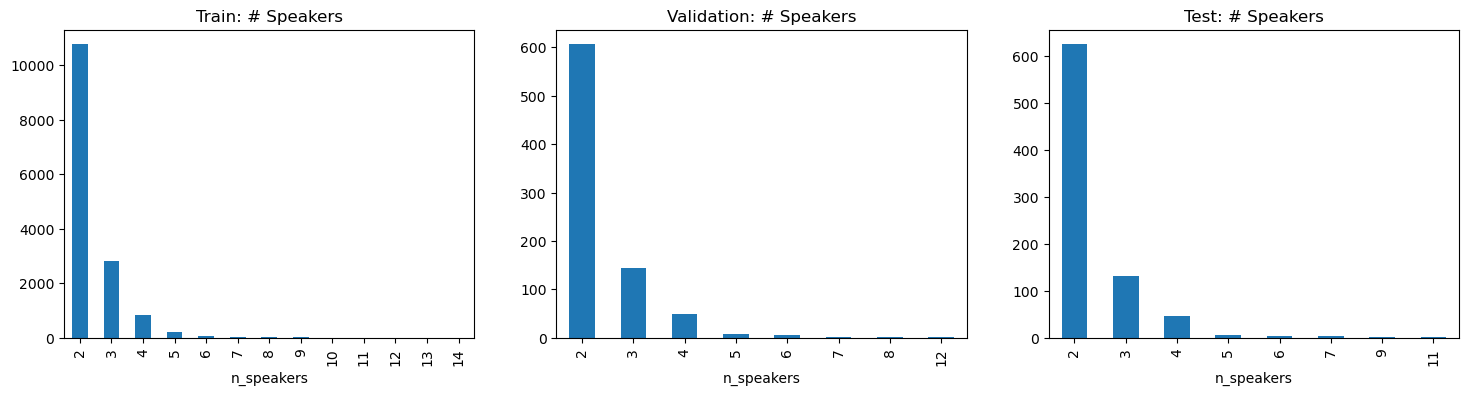

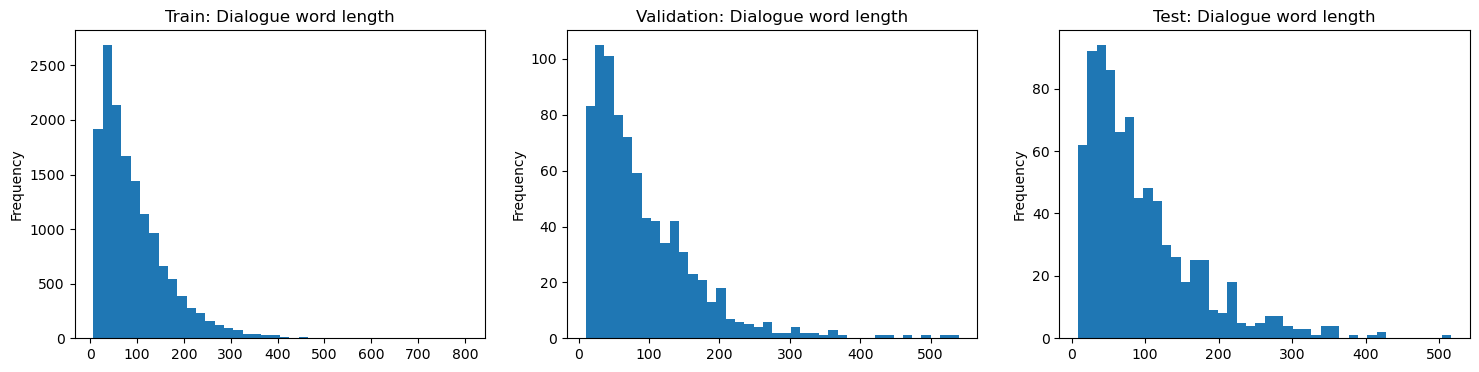

In [7]:
if SHOW_CHARTS:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for ax, df, title in zip(
        axes, [train, val, test], ["Train", "Validation", "Test"]
    ):
        df["n_turns"].plot.hist(ax=ax, bins=40)
        ax.set_title(f"{title}: Turns per dialogue")
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for ax, df, title in zip(
        axes, [train, val, test], ["Train", "Validation", "Test"]
    ):
        df["n_speakers"].value_counts().sort_index().plot.bar(ax=ax)
        ax.set_title(f"{title}: # Speakers")
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for ax, df, title in zip(
        axes, [train, val, test], ["Train", "Validation", "Test"]
    ):
        df["dialogue_word_len"].plot.hist(bins=40, ax=ax)
        ax.set_title(f"{title}: Dialogue word length")
    plt.show()

In [8]:
if SHOW_TABLES:
    metrics = [
        "n_turns",
        "n_speakers",
        "dialogue_word_len",
        "summary_word_len",
        "summary_fraction",
    ]

    combined = pd.DataFrame({
        "train_mean":   train[metrics].mean(),
        "val_mean":     val[metrics].mean(),
        "test_mean":    test[metrics].mean(),
        "train_median": train[metrics].median(),
        "val_median":   val[metrics].median(),
        "test_median":  test[metrics].median(),
    })

    print("=== GLOBAL SUMMARY STATS (Train / Val / Test) ===")
    print("Rows are metrics; columns are means/medians per split.\n")
    display(combined)

=== GLOBAL SUMMARY STATS (Train / Val / Test) ===
Rows are metrics; columns are means/medians per split.



,train_mean,val_mean,test_mean,train_median,val_median,test_median
n_turns,11.167266,10.831296,11.247863,10.00000,9.000000,10.00
n_speakers,2.394610,2.387531,2.360195,2.00000,2.000000,2.00
dialogue_word_len,93.792750,91.641809,95.507937,73.00000,70.000000,74.00
summary_word_len,20.318444,20.283619,20.017094,18.00000,18.000000,18.00
summary_fraction,0.295947,0.301459,0.290010,0.25641,0.266615,0.25


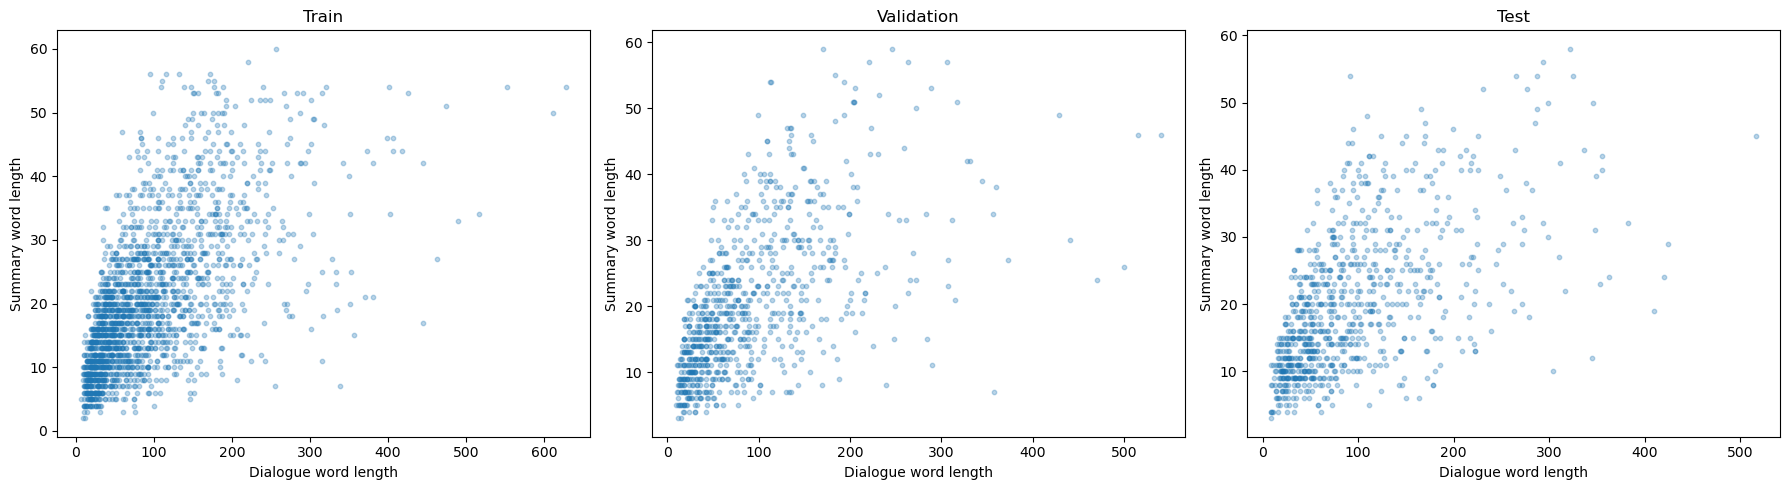

In [9]:
if SHOW_CHARTS:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    datasets = [("Train", train), ("Validation", val), ("Test", test)]

    for ax, (name, df) in zip(axes, datasets):
        sample = df.sample(n=min(2000, len(df)), random_state=SEED)
        ax.scatter(sample["dialogue_word_len"],
                   sample["summary_word_len"],
                   alpha=0.3, s=10)
        ax.set_title(f"{name}")
        ax.set_xlabel("Dialogue word length")
        ax.set_ylabel("Summary word length")

    plt.tight_layout()
    plt.show()

In [10]:
if SHOW_TABLES:
    print("=== DIALOGUE vs SUMMARY WORD LENGTH (SAMPLE POINTS) ===")
    print("Each table uses the same random sample as the scatter plots.\n")

    for name, df in [("Train", train), ("Validation", val), ("Test", test)]:
        sample = df.sample(n=min(2000, len(df)), random_state=SEED)
        table = sample[["dialogue_word_len", "summary_word_len"]].reset_index(drop=True)

        print(f"\n--- {name.upper()} ---")
        # limit rows so it’s not insane to scroll / paste into an LLM
        display(table.head(100))

=== DIALOGUE vs SUMMARY WORD LENGTH (SAMPLE POINTS) ===
Each table uses the same random sample as the scatter plots.


--- TRAIN ---


,dialogue_word_len,summary_word_len
0,37,5
1,474,51
2,92,15
3,21,6
4,299,34
...,...,...
95,38,12
96,139,28
97,45,20
98,47,11



--- VALIDATION ---


,dialogue_word_len,summary_word_len
0,88,21
1,27,12
2,81,20
3,99,17
4,52,12
...,...,...
95,103,28
96,12,3
97,25,13
98,87,20



--- TEST ---


,dialogue_word_len,summary_word_len
0,106,30
1,73,30
2,68,16
3,59,12
4,121,19
...,...,...
95,63,9
96,224,33
97,99,21
98,37,15


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(
    corpus,
    ngram_range=(1, 1),
    top_k=20,
):
    """
    Compute top-k n-grams from a list of texts.
    Returns (ngrams, counts) as two arrays.
    """
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(corpus)
    counts = np.asarray(X.sum(axis=0)).ravel()
    
    vocab = np.array(vectorizer.get_feature_names_out())
    top_idx = counts.argsort()[::-1][:top_k]
    
    return vocab[top_idx], counts[top_idx]  

In [12]:
def compute_top_ngrams_for_splits(
    datasets_dict,        # {"train": df, "val": df, "test": df}
    column="dialogue",    # or "summary"
    ngram_range=(1,1),
    top_k=20
):
    results = {}
    for name, df in datasets_dict.items():
        corpus = df[column].tolist()
        ngrams, counts = top_ngrams(corpus, ngram_range=ngram_range, top_k=top_k)
        results[name] = (ngrams, counts)
    return results

In [13]:
def plot_ngram_row(ngram_results, title_prefix):
    if not SHOW_CHARTS:
        return

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ax, (split, (ngrams, counts)) in zip(axes, ngram_results.items()):
        y = np.arange(len(ngrams))
        ax.barh(y, counts)
        ax.set_yticks(y)
        ax.set_yticklabels(ngrams)
        ax.invert_yaxis()
        ax.set_title(f"{title_prefix} — {split}")
    plt.tight_layout()
    plt.show()

In [14]:
def show_ngram_tables(ngram_results, title_prefix):
    if not SHOW_TABLES:
        return

    for split, (ngrams, counts) in ngram_results.items():
        print(f"\n=== {title_prefix} — {split.upper()} ===")
        display(pd.DataFrame({"ngram": ngrams, "count": counts}))

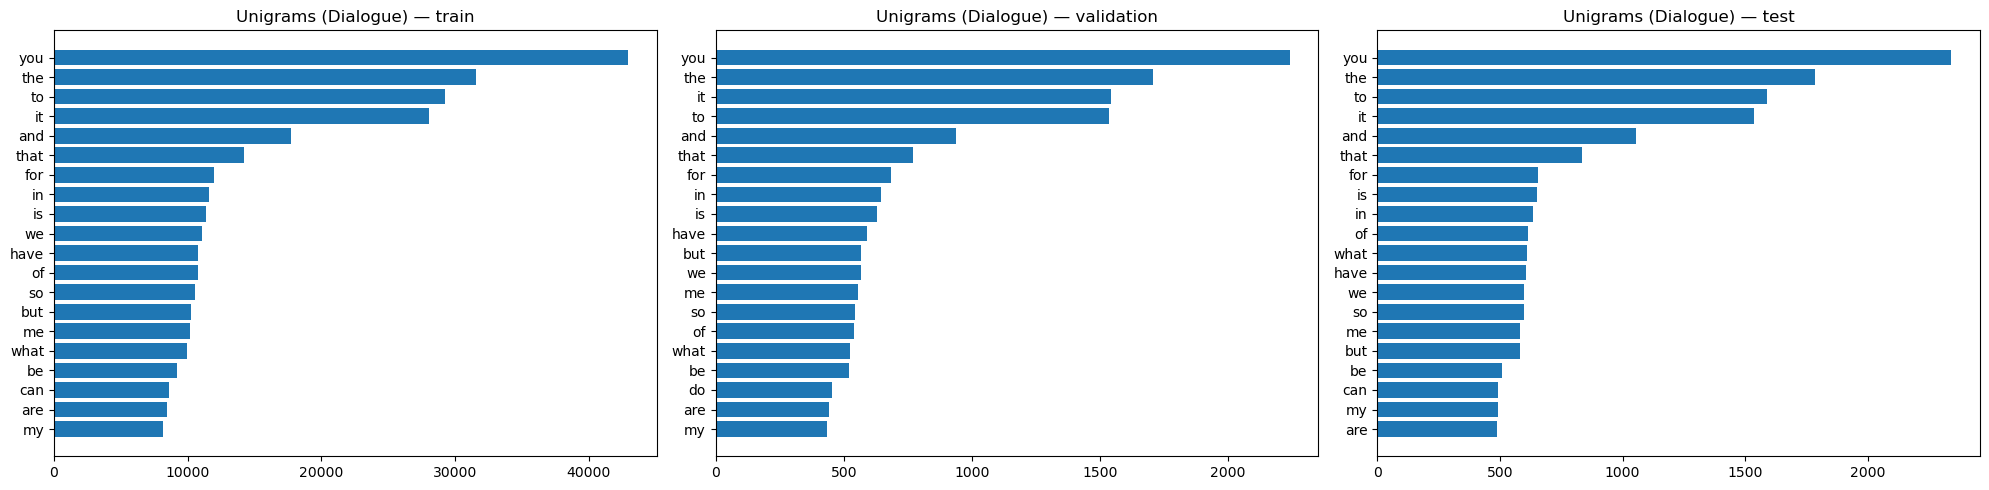


=== Unigrams (Dialogue) — TRAIN ===


,ngram,count
0,you,42926
1,the,31583
2,to,29226
3,it,28066
4,and,17752
5,that,14180
6,for,11989
7,in,11600
8,is,11343
9,we,11077



=== Unigrams (Dialogue) — VALIDATION ===


,ngram,count
0,you,2240
1,the,1708
2,it,1541
3,to,1535
4,and,938
5,that,772
6,for,683
7,in,644
8,is,631
9,have,591



=== Unigrams (Dialogue) — TEST ===


,ngram,count
0,you,2340
1,the,1784
2,to,1587
3,it,1536
4,and,1054
5,that,833
6,for,655
7,is,650
8,in,634
9,of,613


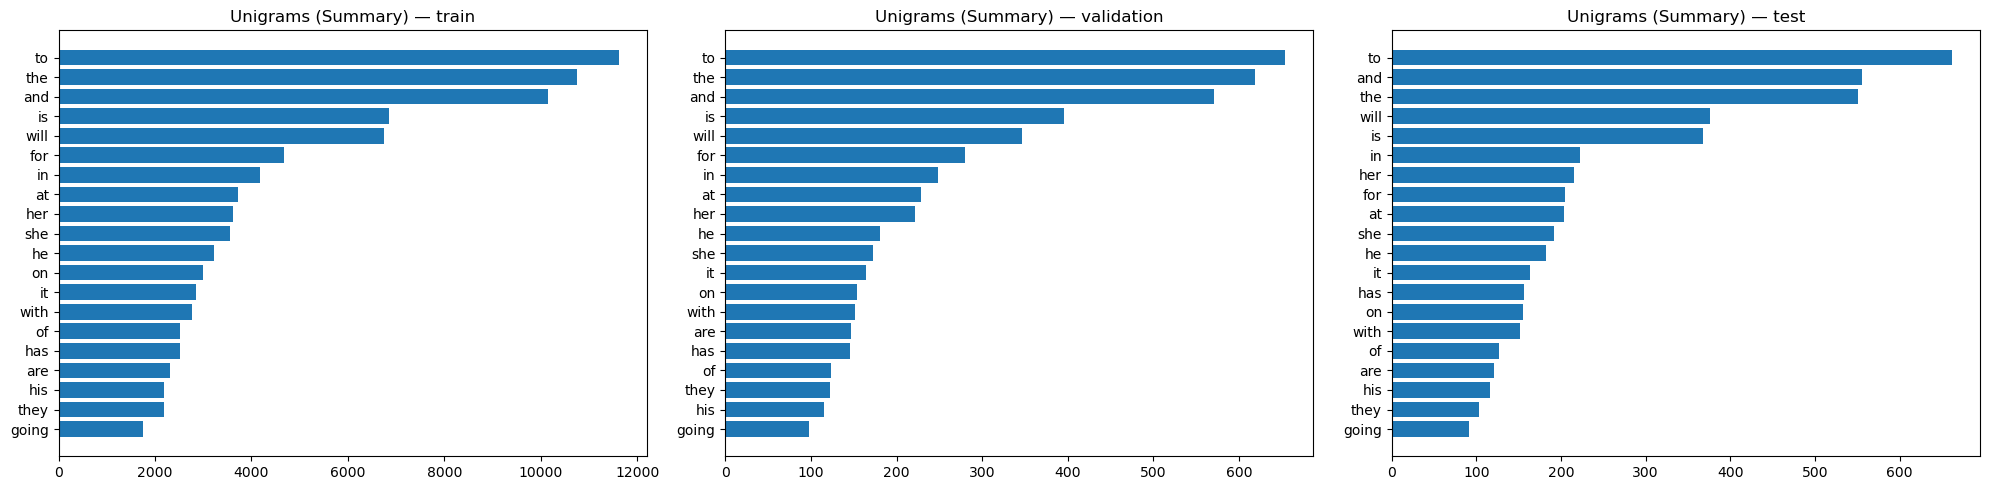


=== Unigrams (Summary) — TRAIN ===


,ngram,count
0,to,11618
1,the,10756
2,and,10146
3,is,6850
4,will,6748
5,for,4678
6,in,4172
7,at,3715
8,her,3609
9,she,3547



=== Unigrams (Summary) — VALIDATION ===


,ngram,count
0,to,654
1,the,618
2,and,571
3,is,395
4,will,346
5,for,280
6,in,249
7,at,229
8,her,222
9,he,181



=== Unigrams (Summary) — TEST ===


,ngram,count
0,to,662
1,and,556
2,the,551
3,will,376
4,is,368
5,in,222
6,her,215
7,for,205
8,at,203
9,she,192


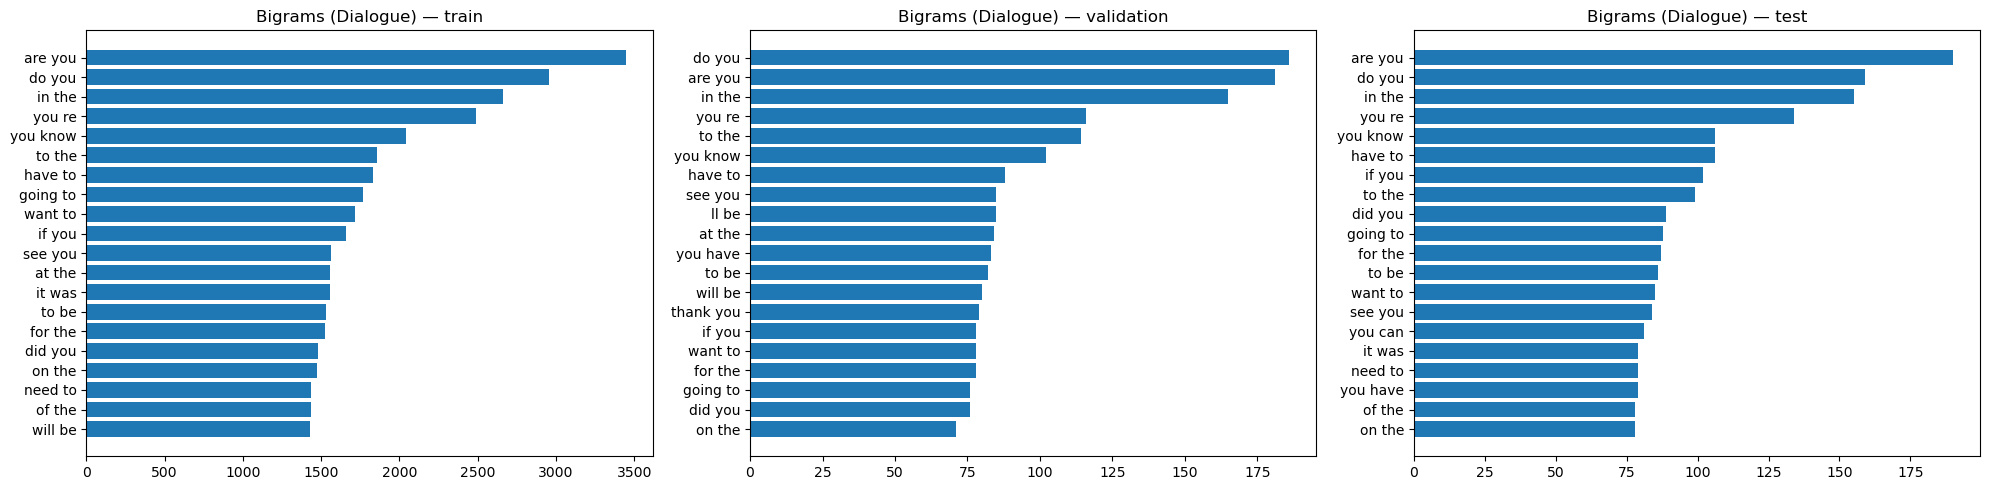


=== Bigrams (Dialogue) — TRAIN ===


,ngram,count
0,are you,3445
1,do you,2957
2,in the,2661
3,you re,2486
4,you know,2040
5,to the,1855
6,have to,1830
7,going to,1769
8,want to,1713
9,if you,1657



=== Bigrams (Dialogue) — VALIDATION ===


,ngram,count
0,do you,186
1,are you,181
2,in the,165
3,you re,116
4,to the,114
5,you know,102
6,have to,88
7,see you,85
8,ll be,85
9,at the,84



=== Bigrams (Dialogue) — TEST ===


,ngram,count
0,are you,190
1,do you,159
2,in the,155
3,you re,134
4,you know,106
5,have to,106
6,if you,102
7,to the,99
8,did you,89
9,going to,88


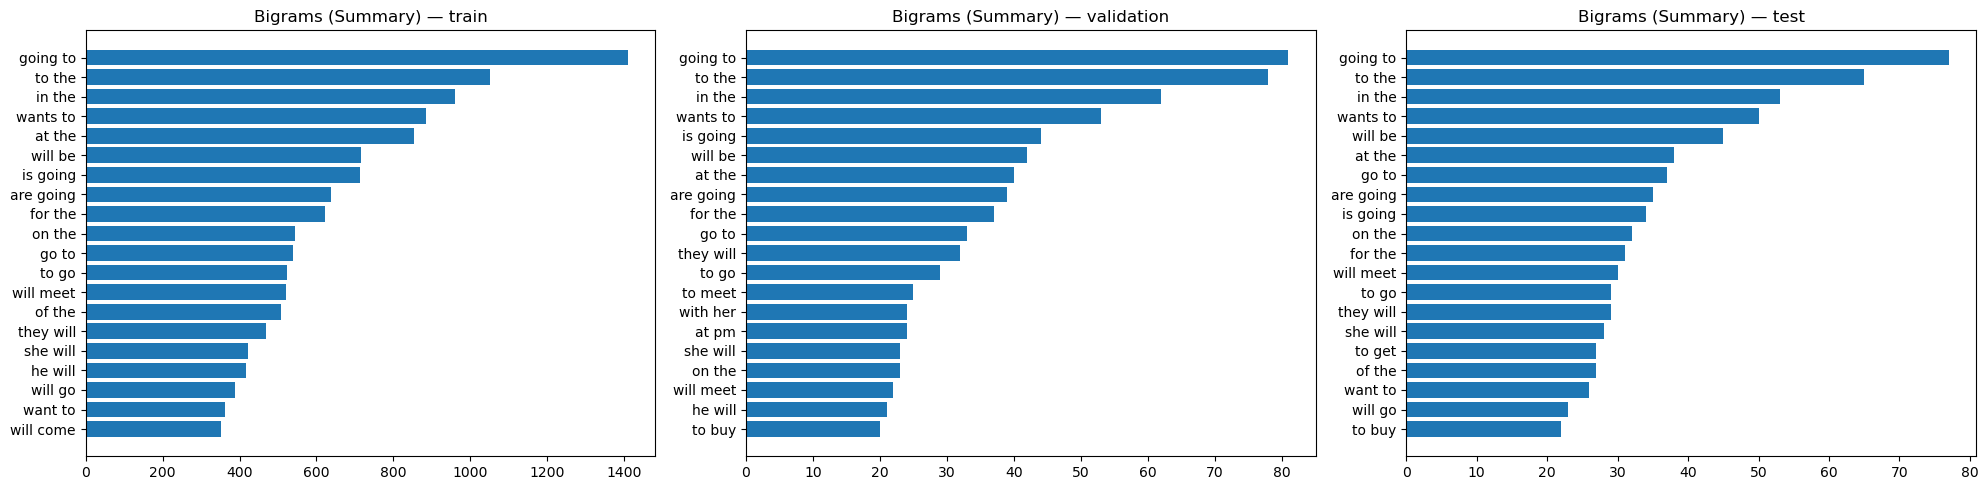


=== Bigrams (Summary) — TRAIN ===


,ngram,count
0,going to,1410
1,to the,1052
2,in the,961
3,wants to,884
4,at the,854
5,will be,716
6,is going,713
7,are going,637
8,for the,621
9,on the,544



=== Bigrams (Summary) — VALIDATION ===


,ngram,count
0,going to,81
1,to the,78
2,in the,62
3,wants to,53
4,is going,44
5,will be,42
6,at the,40
7,are going,39
8,for the,37
9,go to,33



=== Bigrams (Summary) — TEST ===


,ngram,count
0,going to,77
1,to the,65
2,in the,53
3,wants to,50
4,will be,45
5,at the,38
6,go to,37
7,are going,35
8,is going,34
9,on the,32


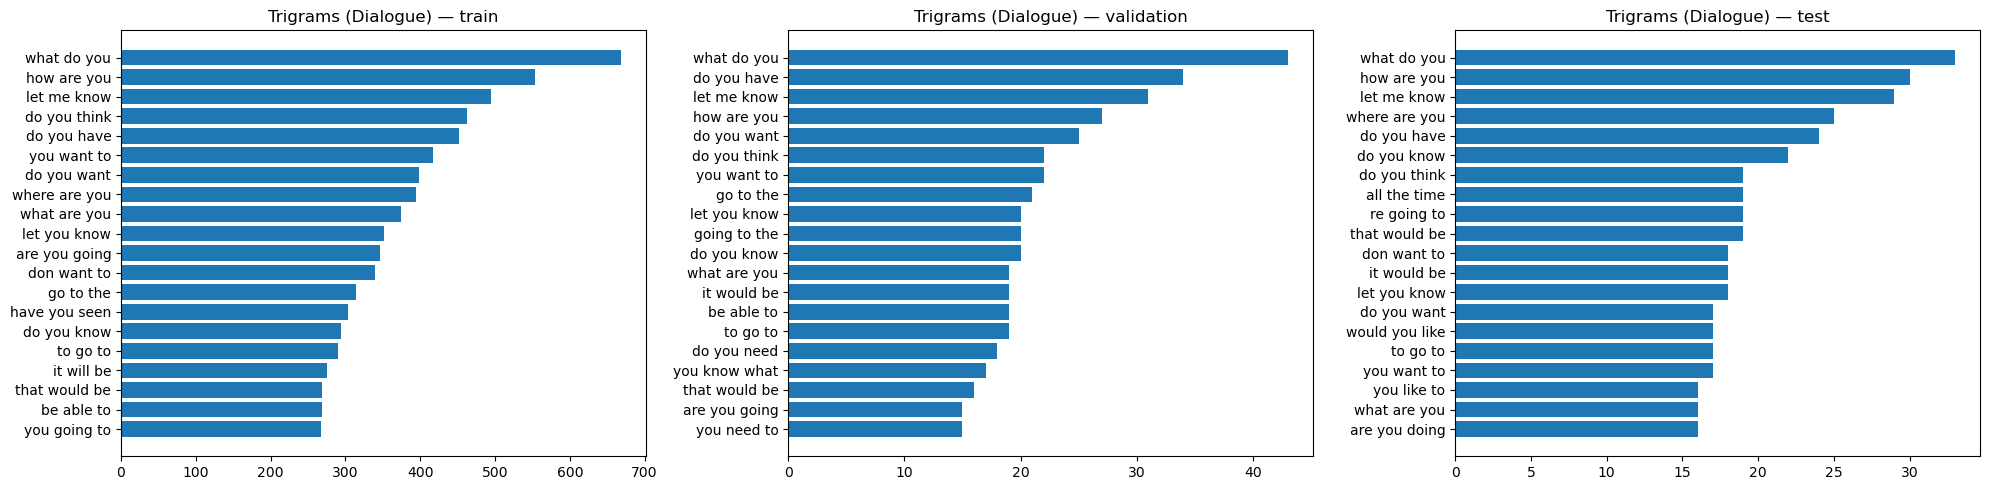


=== Trigrams (Dialogue) — TRAIN ===


,ngram,count
0,what do you,668
1,how are you,553
2,let me know,495
3,do you think,463
4,do you have,452
5,you want to,417
6,do you want,398
7,where are you,394
8,what are you,374
9,let you know,352



=== Trigrams (Dialogue) — VALIDATION ===


,ngram,count
0,what do you,43
1,do you have,34
2,let me know,31
3,how are you,27
4,do you want,25
5,do you think,22
6,you want to,22
7,go to the,21
8,let you know,20
9,going to the,20



=== Trigrams (Dialogue) — TEST ===


,ngram,count
0,what do you,33
1,how are you,30
2,let me know,29
3,where are you,25
4,do you have,24
5,do you know,22
6,do you think,19
7,all the time,19
8,re going to,19
9,that would be,19


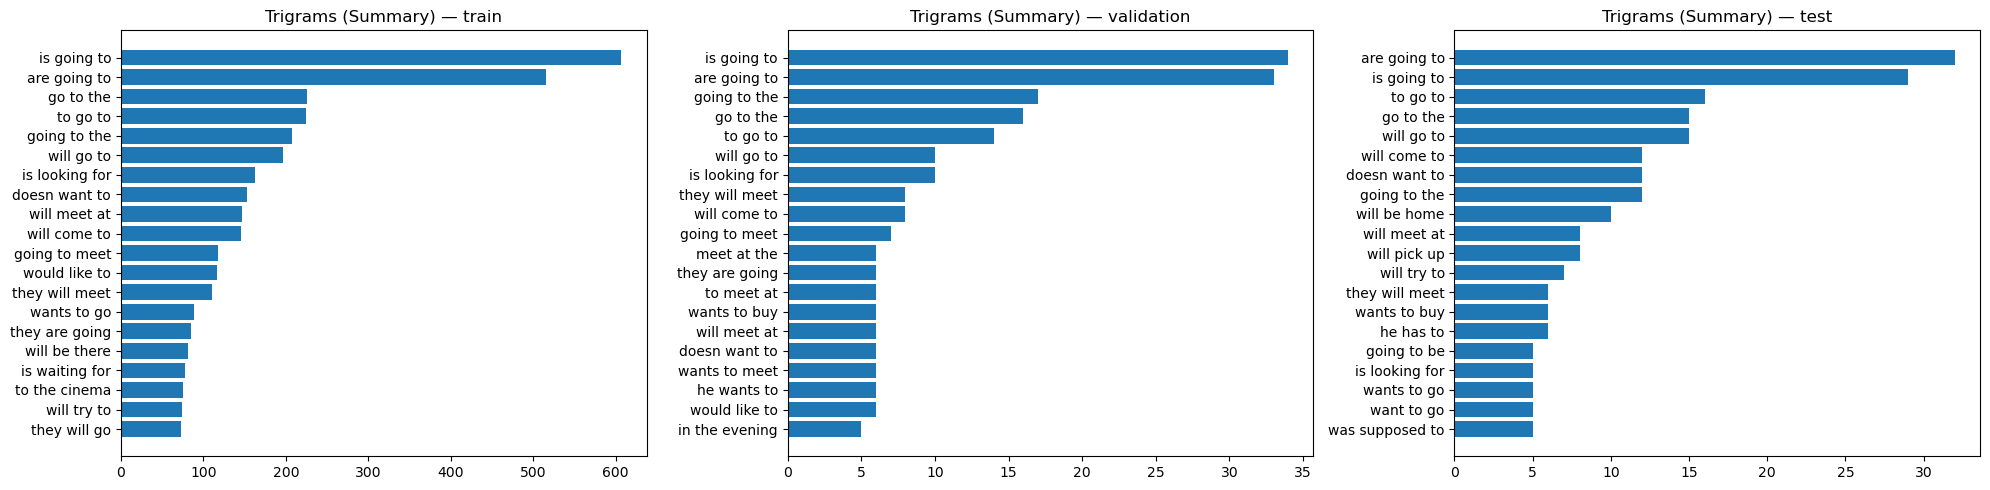


=== Trigrams (Summary) — TRAIN ===


,ngram,count
0,is going to,607
1,are going to,516
2,go to the,226
3,to go to,224
4,going to the,207
5,will go to,196
6,is looking for,163
7,doesn want to,153
8,will meet at,147
9,will come to,146



=== Trigrams (Summary) — VALIDATION ===


,ngram,count
0,is going to,34
1,are going to,33
2,going to the,17
3,go to the,16
4,to go to,14
5,will go to,10
6,is looking for,10
7,they will meet,8
8,will come to,8
9,going to meet,7



=== Trigrams (Summary) — TEST ===


,ngram,count
0,are going to,32
1,is going to,29
2,to go to,16
3,go to the,15
4,will go to,15
5,will come to,12
6,doesn want to,12
7,going to the,12
8,will be home,10
9,will meet at,8


In [15]:
datasets_dict = {
    "train": train,
    "validation": val,
    "test": test
}

# UNIGRAMS (dialogue)
uni_dialogue = compute_top_ngrams_for_splits(datasets_dict, column="dialogue", ngram_range=(1,1))
plot_ngram_row(uni_dialogue, "Unigrams (Dialogue)")
show_ngram_tables(uni_dialogue, "Unigrams (Dialogue)")

# UNIGRAMS (summary)
uni_summary = compute_top_ngrams_for_splits(datasets_dict, column="summary", ngram_range=(1,1))
plot_ngram_row(uni_summary, "Unigrams (Summary)")
show_ngram_tables(uni_summary, "Unigrams (Summary)")

# BIGRAMS (dialogue)
bi_dialogue = compute_top_ngrams_for_splits(datasets_dict, column="dialogue", ngram_range=(2,2))
plot_ngram_row(bi_dialogue, "Bigrams (Dialogue)")
show_ngram_tables(bi_dialogue, "Bigrams (Dialogue)")

# BIGRAMS (summary)
bi_summary = compute_top_ngrams_for_splits(datasets_dict, column="summary", ngram_range=(2,2))
plot_ngram_row(bi_summary, "Bigrams (Summary)")
show_ngram_tables(bi_summary, "Bigrams (Summary)")

# TRIGRAMS (dialogue)
tri_dialogue = compute_top_ngrams_for_splits(datasets_dict, column="dialogue", ngram_range=(3,3))
plot_ngram_row(tri_dialogue, "Trigrams (Dialogue)")
show_ngram_tables(tri_dialogue, "Trigrams (Dialogue)")

# TRIGRAMS (summary)
tri_summary = compute_top_ngrams_for_splits(datasets_dict, column="summary", ngram_range=(3,3))
plot_ngram_row(tri_summary, "Trigrams (Summary)")
show_ngram_tables(tri_summary, "Trigrams (Summary)")

----
# Key Takeaways
----

### 1. Structure is simple and consistent across the dataset

- **Conversations are short-ish:** train split averages ~11 turns per dialogue, with medians around 9–10.
- **Mostly 2–3 speakers:** almost all dialogues involve two speakers; three is less common.
- Validation and test splits show **similar distributions** (checked only for sanity), so no major shift across splits.

**Modeling implication (based on train):**  
A standard seq2seq model is appropriate. The dataset does not require special handling for long or highly multi-party conversations.

---

### 2. Lengths and compression

- **Dialogue length (train):** mean ~90–95 words, median ~70–75, with a long tail past 500 words.
- **Summary length (train):** mean ~20 words, median ~18 words.
- **Summary fraction:** roughly ~0.28–0.30 on the train set (summaries are about 28-30% as long as dialogues).


**Modeling implication (based on train):**
- The model must compress chats to roughly **one third or less** of their original size.
- A source length around **512 tokens** comfortably covers the long tail in *train*.
- A target length around **64–128 tokens** fits the typical summary length.
- For the longest dialogues, consistent truncation matters.

Validation/test distributions are shown only to confirm they follow the same shape.

---

### 3. Dialogue vs summary length relationship

- In the train split, longer dialogues correlate with longer summaries, but the relationship saturates: summaries rarely exceed 20–40 words.
- Validation/test show the same pattern (again, only checked for similarity).

**Modeling implication (based on train):**  
It is reasonable to **cap summary length**, since the task does not reward very long outputs even for long inputs.

---

### 4. N-gram patterns

Across splits, patterns align well. In *train*:

- **Dialogues:** informal, chatty, full of greetings, questions, and first-person pronouns.
- **Summaries:** more abstract, compressed, and action-oriented (“agrees”, “decides”, “plans”), with a shift toward third-person narration.

Validation/test n-grams are inspected only to confirm similar distributional behavior.

**Modeling implication (based on train):**  
The model must learn a **style shift**:
- from noisy, multi-speaker, first-person chat  
- to clean, concise, third-person summaries that emphasize decisions and events.

---

### 5. Overall

- The train set shows stable, well-behaved structure for dialogue summarization.  
- Validation/test confirm that the same patterns hold, supporting fair evaluation.
- The task is **real compression** with a clear stylistic transformation.
- Only the longest dialogues challenge typical max-length settings.

Training decisions drawn from this notebook:
- `max_source_length` and `max_target_length` derived from **train** length statistics  
- beam search kept compact due to short target lengths  
- truncation strategy guided by the long-tail examples in **train**